In [1]:
import os
import shutil
import sys
import subprocess
import requests
import json
import re
import time
import yt_dlp
import html
import time
from datetime import datetime
from dateutil import parser
from bs4 import BeautifulSoup
from urllib.parse import urlparse, quote_plus

# load json links
wallpaper_engine_appid = 431960
BASE_DIR = '/Users/bebeal/Programs/ProjectionSorcery'
LOCAL_WORKSHOP_DIR = './cache/workshop'
YOUTUBE_DOWNLOAD_DIR = './cache/youtube'
REDDIT_DOWNLOAD_DIR = './cache/reddit'
file='wallpapers.json'
directory = './cache'
file_path = os.path.join(directory, file)
if os.path.exists(file_path):
    links = json.load(open(file_path))

links
links.append(['https://i.redd.it/sfnasdkjfsnsdlka.png', 'https://steamcommunity.com/sharedfiles/filedetails/?id=3257943478'])


In [2]:
# import `download_steam_workshop` function from `downloader.ipynb`
%run downloader.ipynb import download_steam_workshop_item, download_reddit_content, download_youtube_video, clean_steamcmd
from tqdm.notebook import tqdm

# ex: download_steam_workshop_item('3257943478')
path_data = []

def get_link(link):
  path = None
  if 'steamcommunity.com/sharedfiles/filedetails' in link:
    print('\nSteam Workshop:', link)
    item_id = urlparse(link).query.split('?id=')[-1].replace('id=', '')
    if item_id:
      path = download_steam_workshop_item(item_id)
  elif 'i.redd.it' in link:
    print('\nReddit Image:', link)
    # this one is just everything after the last slash
    content_id = link.split('/')[-1]
    if content_id:
      path = download_reddit_content(content_id)
  elif 'youtube.com' in link:
    print('\nYouTube Video:', link)
    # query for &v=VIDEO_ID via v parameter
    video_id = urlparse(link).query.split('&v=')[-1].replace('v=', '')
    if video_id:
      path = download_youtube_video(video_id)
  else:
    print('Unsupported link:', link)
  if path is None:
    print('Failed to download:', link)
  return path
    
wallpaper_paths = []
for pair_of_links in tqdm(links, desc="Downloading wallpaper data", position=0):
  static = get_link(pair_of_links[0])
  dynamic = get_link(pair_of_links[1])
  wallpaper = {
    'static': static,
    'dynamic': dynamic
  }
  wallpaper_paths.append(wallpaper)
  

Cache hit at ./cache/workshop/3257943478.mp4



Reddit Image: https://i.redd.it/xv7ooelxqbu61.png
Cache hit at ./cache/reddit/xv7ooelxqbu61.png

Steam Workshop: https://steamcommunity.com/sharedfiles/filedetails/?id=1547246726
Cache hit at ./cache/workshop/1547246726.png

Reddit Image: https://i.redd.it/rz5gjjnj2nm91.png
Cache hit at ./cache/reddit/rz5gjjnj2nm91.png

Steam Workshop: https://steamcommunity.com/sharedfiles/filedetails/?id=2860536335%5D(https://steamcommunity.com/sharedfiles/filedetails/?id=2860536335)
Invalid workshop ID 2860536335), using 2860536335
Cache hit at ./cache/workshop/2860536335.pkg

Reddit Image: https://i.redd.it/a30z1fq8phr91.png
Cache hit at ./cache/reddit/a30z1fq8phr91.png

Steam Workshop: https://steamcommunity.com/sharedfiles/filedetails/?id=2871089644
Cache hit at ./cache/workshop/2871089644.pkg

Reddit Image: https://i.redd.it/x3r0vke8f6u71.jpg
Cache hit at ./cache/reddit/x3r0vke8f6u71.jpg

Steam Workshop: https://steamcommunity.com/sharedfiles/filedetails/?id=2155933185
Cache hit at ./cache/work

In [3]:
# clean_steamcmd()
# filter out pkg for now until I figure out how to handle them
dataset = list(filter(lambda x: x['dynamic'] is not None and x['dynamic'].split('.')[-1] != "None" and x['dynamic'].split('.')[-1] not in ['pkg'], wallpaper_paths))
print(f'{len(dataset)} wallpapers downloaded')
dataset

8 wallpapers downloaded


[{'static': './cache/reddit/xv7ooelxqbu61.png',
  'dynamic': './cache/workshop/1547246726.png'},
 {'static': './cache/reddit/53sr7ppxlmv91.png',
  'dynamic': './cache/reddit/gktn6pj6gls91.jpg'},
 {'static': './cache/reddit/pxye54sj4y881.jpg',
  'dynamic': './cache/workshop/2668417858.mp4'},
 {'static': './cache/reddit/7775imab3za41.png',
  'dynamic': './cache/reddit/fd63dl3pfog11.jpg'},
 {'static': './cache/reddit/ycn03d7ildi51.png',
  'dynamic': './cache/workshop/2229840856.mp4'},
 {'static': './cache/reddit/d5j0rp2wt1r71.png',
  'dynamic': './cache/youtube/oTY1T35LEp0.mp4'},
 {'static': './cache/reddit/03332nstsmj51.jpg',
  'dynamic': './cache/workshop/2212148814.mp4'},
 {'static': './cache/reddit/sfnasdkjfsnsdlka.png',
  'dynamic': './cache/workshop/3257943478.mp4'}]

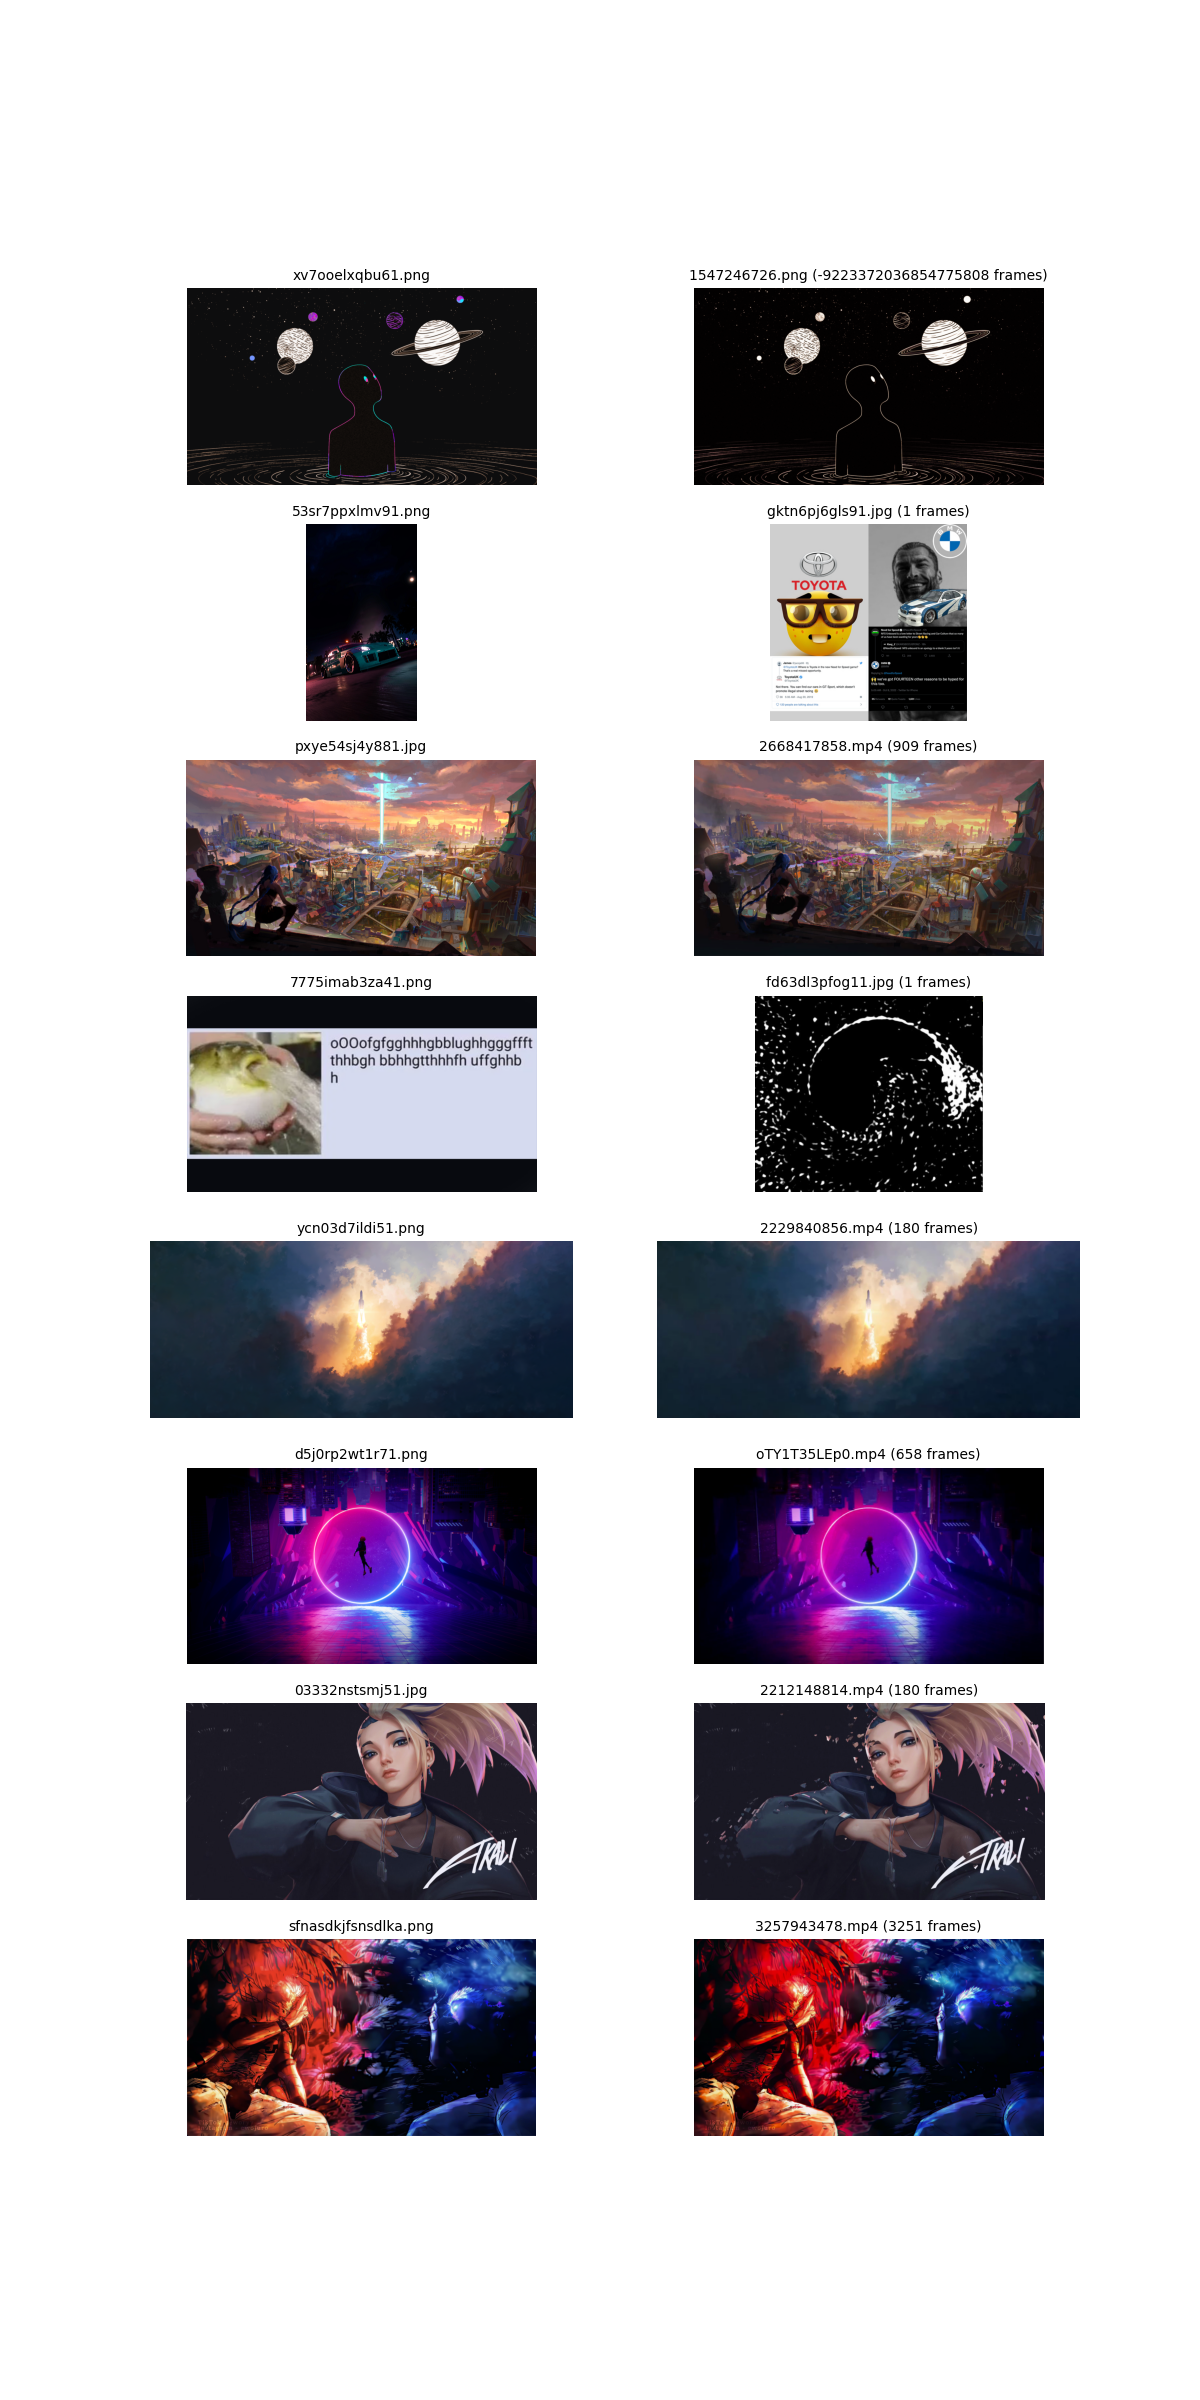

In [4]:
%matplotlib widget

import cv2
import matplotlib.pyplot as plt
import numpy as np
from ipywidgets import jslink, IntSlider, HBox, VBox, Play, Layout, Label


# dataset = [{'static': './cache/reddit/xv7ooelxqbu61.png',
#   'dynamic': './cache/workshop/1921855792.mp4'}]

frame = 0
max_frames = 0
for entry in dataset:
    cap = cv2.VideoCapture(entry['dynamic'])
    frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    cap.release()
    max_frames = max(max_frames, frames)
page = 0
pagination = 10
total_pages = len(dataset) // pagination
num_plots = min(len(dataset), pagination)
fig, axes = plt.subplots(num_plots, 2, figsize=(12, num_plots * 3))
fig.set_label(' ')

# special case for when theres 1 entry, we'll expand axes to 2D so 2D indexing always works regardless of number of entries
if len(dataset) == 1:
    axes = np.expand_dims(axes, axis=0)

def blank_image(width=1920, height=1080):
  return np.zeros((height, width, 3), dtype=np.uint8)

def clear_prev_plot():
  for ax in axes.flatten():
      ax.clear()

def get_entries(page):
  start = page * pagination
  end = min(start + pagination, len(dataset))
  return dataset[start:end]

def plot_entries(page, frame):
    clear_prev_plot()
    entries = get_entries(page)
    for i, entry in enumerate(entries):
        static = cv2.imread(entry['static']) if 'static' in entry else blank_image()
        cap = cv2.VideoCapture(entry['dynamic'])
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        cap.set(cv2.CAP_PROP_POS_FRAMES, min(frame, total_frames - 1))
        ret, dynamic = cap.read()
        dynamic = dynamic if ret else blank_image()
        axes[i, 0].imshow(cv2.cvtColor(static, cv2.COLOR_BGR2RGB))
        axes[i, 1].imshow(cv2.cvtColor(dynamic, cv2.COLOR_BGR2RGB))
        static_title = entry["static"].split('/')[-1] if 'static' in entry else 'None'
        dynamic_title = entry["dynamic"].split('/')[-1]
        axes[i, 0].set_title(f'{static_title}', fontsize=10)
        axes[i, 1].set_title(f'{dynamic_title} ({total_frames} frames)', fontsize=10)
        axes[i, 0].axis('off')
        axes[i, 1].axis('off')
    fig.canvas.draw_idle()

page_slider = IntSlider(min=1, max=total_pages + 1, value=page+1, description='Page:', readout=True, layout=Layout(width='60%'))
total_pages_label = Label(value=f"/{total_pages + 1}", layout=Layout(width='auto'))

frame_slider = IntSlider(min=1, max=max_frames + 1, value=frame + 1, continuous_update=False, description='Frame:', readout=True, layout=Layout(width='60%'))
total_frames_label = Label(value=f"/{max_frames + 1}", layout=Layout(width='auto'))

# 60 fps: 1 frame per 16.67 ms is 60 frames per second
# 30 fps: 1 frame per 33.33 ms is 30 frames per second
play_button = Play(value=0, min=0, max=max_frames, step=1, interval=16.67, description='Play', disabled=False, layout=Layout(width='auto', margin='0 0 0 10px'))

page_controller = HBox([page_slider, total_pages_label], layout=Layout(justify_content='flex-start'))
frame_controller = HBox([frame_slider, total_frames_label, play_button], layout=Layout(justify_content='flex-start'))

def update_plot(change):
    global frame
    global page
    page = page_slider.value - 1
    frame = frame_slider.value - 1
    plot_entries(page, frame)

page_slider.observe(update_plot, names='value')
frame_slider.observe(update_plot, names='value')

jslink((play_button, 'value'), (frame_slider, 'value'))
controls = VBox([page_controller, frame_controller])
display(controls)

plot_entries(page, frame)

holy shit this baked ass code kinda works. But the blunder was in filtering/isolating posts with animation requests (which indicated it had both static, dynamic pieces)

you can just parse the reddit for dynamic and take the first frame to be the static bruh. no more 30mg buddy

make sure to run this through something of low intelligence to parse out the abominations like the 4th row